# Germany New Heavy Vehicle Registrations Plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import de_kba_datagrabber as kba
from utils import PowerType

In [2]:
kba.ensure_up_to_date()

In [3]:
ev_data = kba.fz28_1_aggregated()

## Share of Power Types for LKW (Light / Medium Trucks) and Sattelzugmaschinen (Tractor-Trailer)

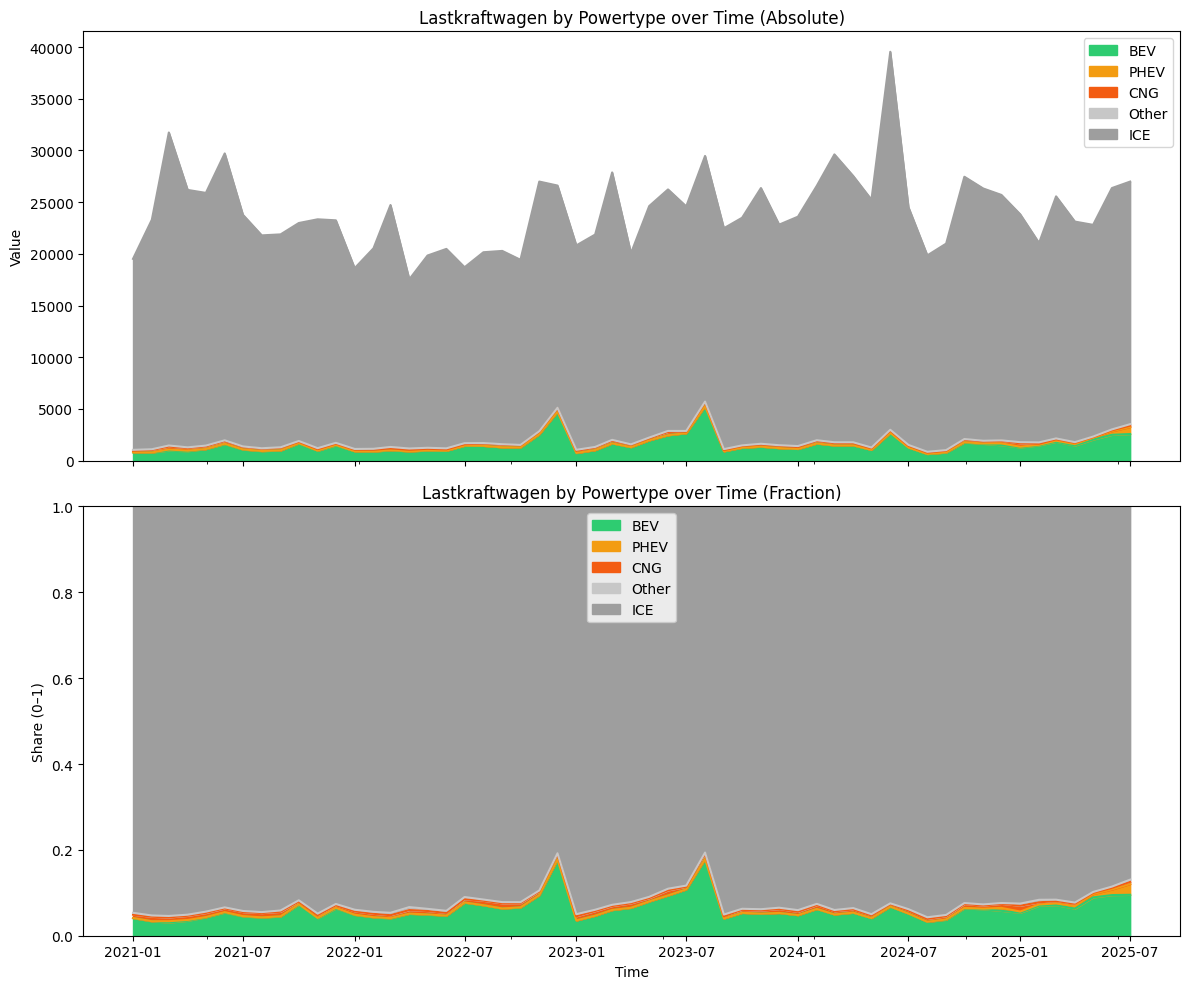

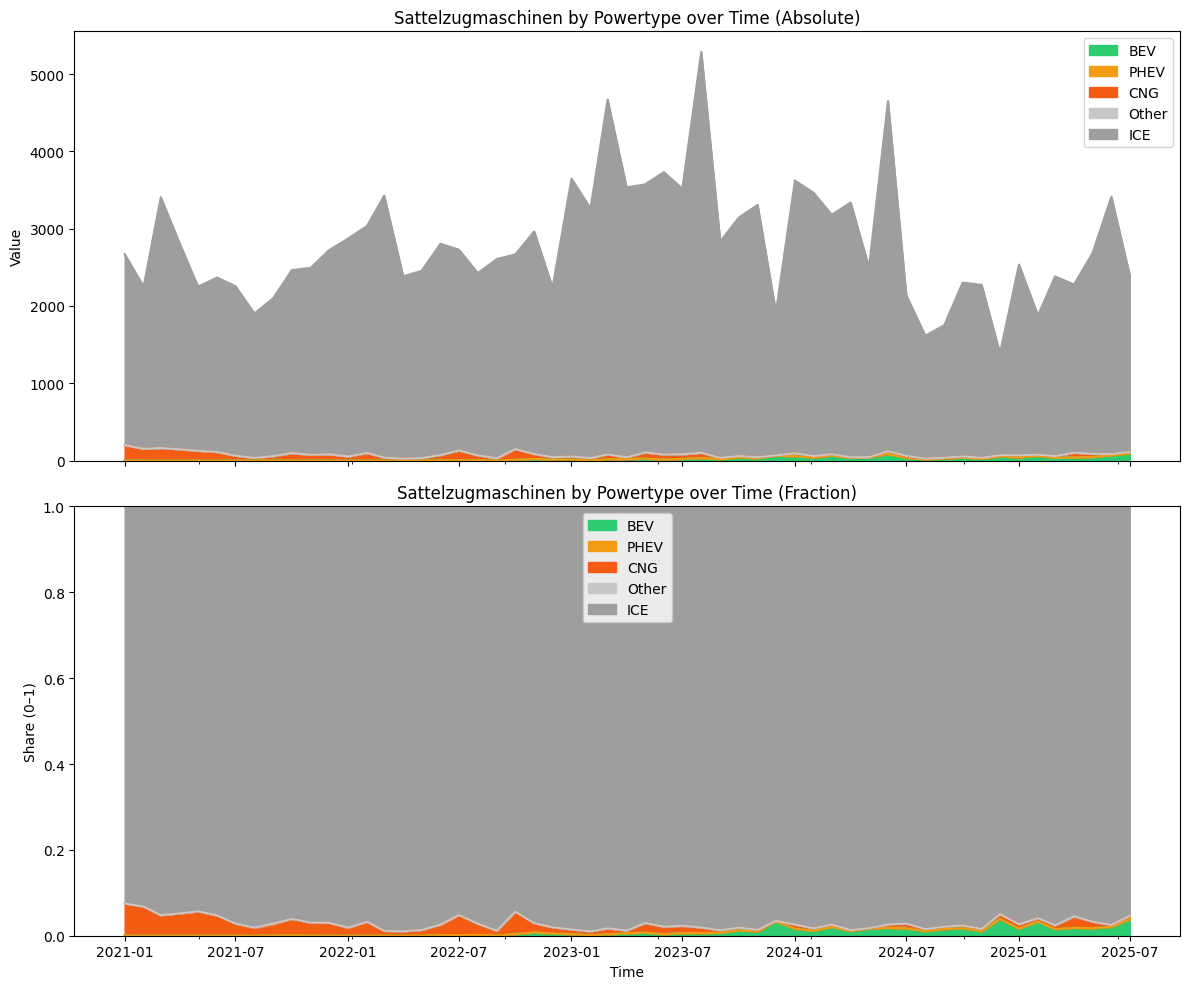

In [4]:

def plot_by_power_type(kfztype):
    order = ['BEV', 'PHEV', 'CNG', 'Other', 'ICE']
    colors = {
        'BEV': '#2ecc71',  # green
        'PHEV': '#f39c12',  # orange
        'CNG': '#f35c12',  # orange
        'Other': '#c7c7c7', # dark grey
        'ICE': '#9e9e9e' # grey
    }

    df_plot = ev_data.xs(kfztype, axis=1, level=0, drop_level=True).sort_index()

    get_name = lambda c: getattr(c, 'value', str(c))
    names = {c: get_name(c) for c in df_plot.columns}

    other_cols = [c for c, n in names.items() if n not in {'BEV', 'PHEV', 'ICE', 'CNG'}]

    df_plot2 = pd.DataFrame({
        'BEV': df_plot[PowerType.BEV],
        'PHEV': df_plot[PowerType.PHEV],
        'CNG': df_plot[PowerType.CNG],
        'Other': df_plot[other_cols].sum(axis=1) if other_cols else 0,
        'ICE': df_plot[PowerType.ICE],
    }).reindex(columns=order)

    df_share2 = df_plot2.div(df_plot2.sum(axis=1), axis=0)

    color_list = [colors[k] for k in order]

    fig2, axes2 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    df_plot2.plot(kind='area', stacked=True, ax=axes2[0], color=color_list)
    axes2[0].set_title(f'{kfztype} by Powertype over Time (Absolute)')
    axes2[0].set_ylabel('Value')

    df_share2.plot(kind='area', stacked=True, ax=axes2[1], color=color_list)
    axes2[1].set_title(f'{kfztype} by Powertype over Time (Fraction)')
    axes2[1].set_xlabel('Time')
    axes2[1].set_ylabel('Share (0–1)')
    axes2[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

plot_by_power_type('Lastkraftwagen')
plot_by_power_type('Sattelzugmaschinen')

## Comparison of BEV Share over time

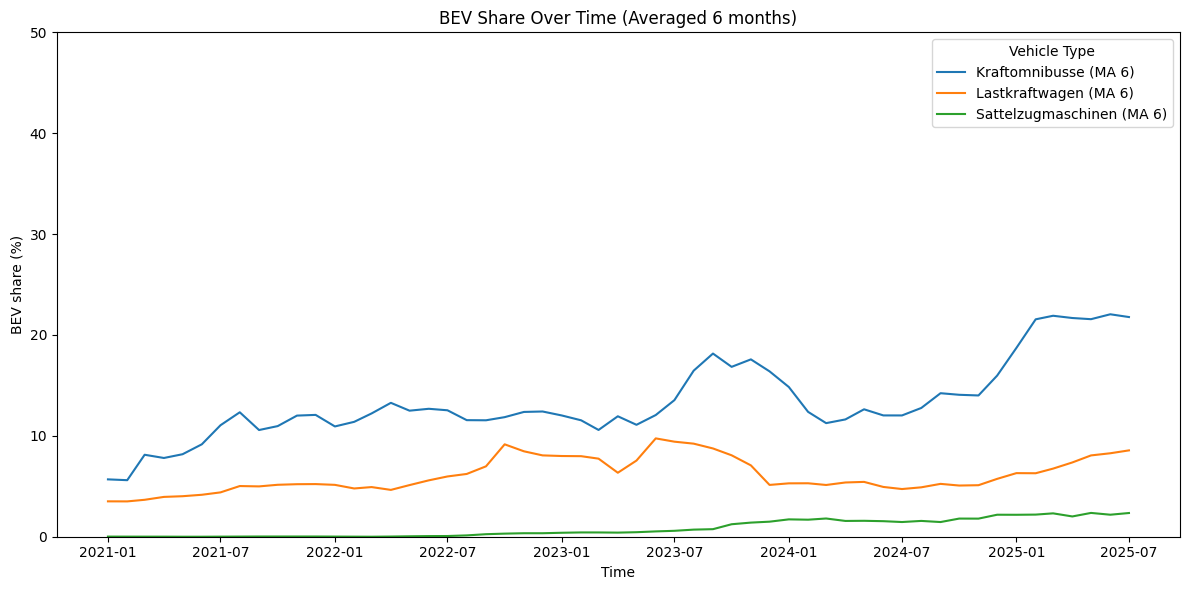

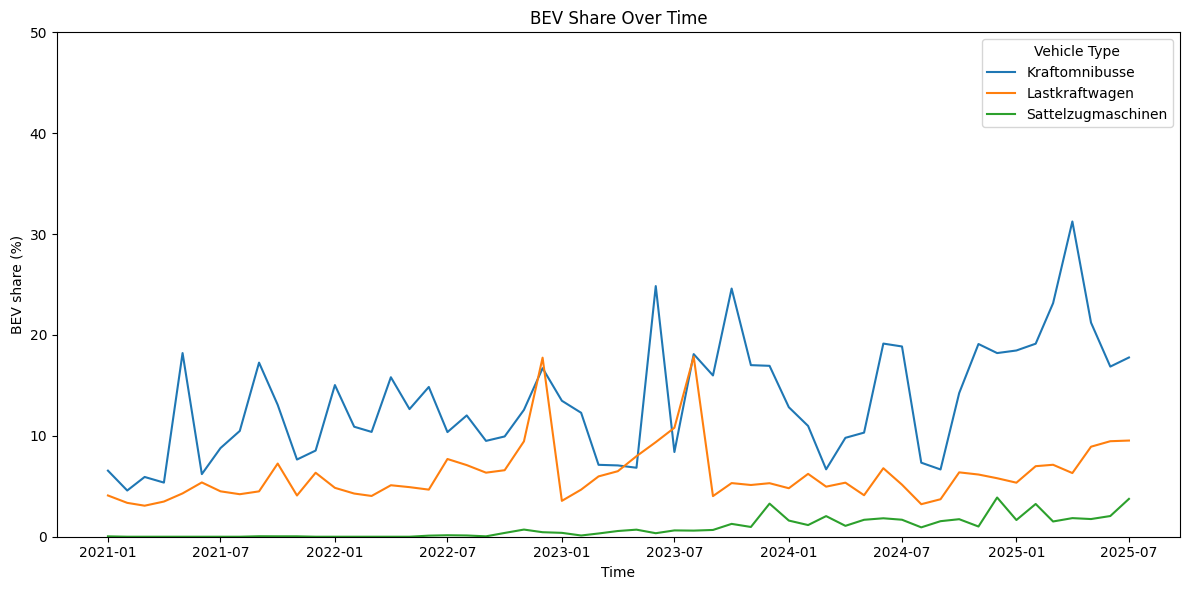

In [5]:
monthy_average_window = 6
types = ['Kraftomnibusse', 'Lastkraftwagen', 'Sattelzugmaschinen']

def plot_bev_share(types, ma_window=1):
    plt.figure(figsize=(12, 6))
    for t in types:
        sub = ev_data.xs(t, axis=1, level=0, drop_level=True).sort_index()
        total = pd.to_numeric(sub.sum(axis=1), errors='coerce').astype('float64')
        bev = sub[PowerType.BEV] if PowerType.BEV in sub.columns else pd.Series(0, index=sub.index, dtype='float64')
        bev = pd.to_numeric(bev, errors='coerce').astype('float64')
        share_pct = bev.div(total.where(total > 0)).fillna(0.0) * 100
        if ma_window <= 1:
            share_pct.plot(label=f'{t}')
        else:
            share_smoothed = share_pct.rolling(window=ma_window, min_periods=1, center=True).mean()
            share_smoothed.plot(label=f'{t} (MA {ma_window})')

    plt.ylim(0, 50)
    plt.ylabel('BEV share (%)')
    plt.xlabel('Time')
    plt.title('BEV Share Over Time' if ma_window <= 1 else f'BEV Share Over Time (Averaged {ma_window} months)')
    plt.legend(title='Vehicle Type')
    plt.tight_layout()
    plt.show()

plot_bev_share(types, monthy_average_window)
plot_bev_share(types)

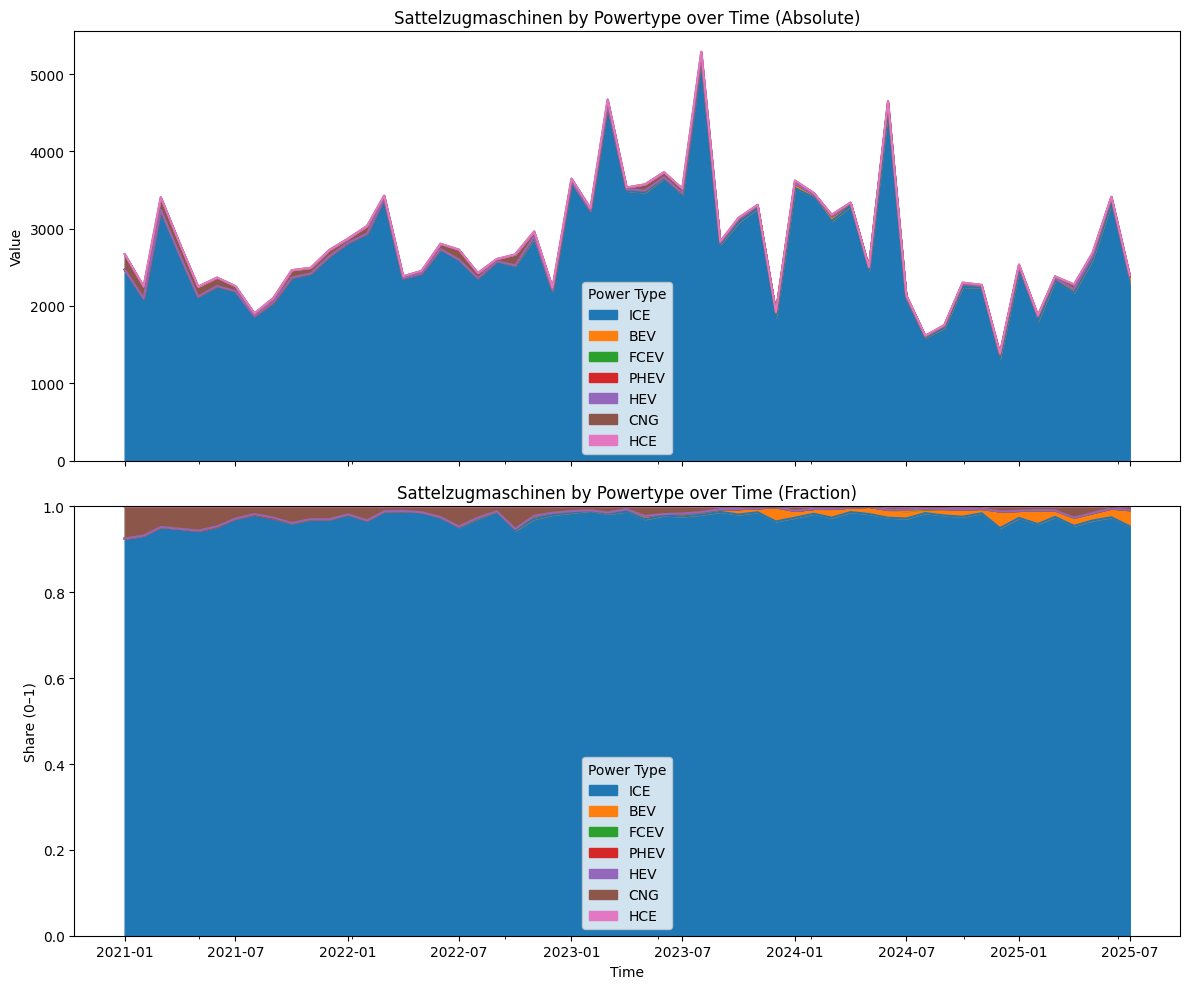

In [6]:
#kfztype = 'Lastkraftwagen'
kfztype = 'Sattelzugmaschinen'

df_plot = ev_data.xs(kfztype, axis=1, level=0, drop_level=True).sort_index()
df_share = df_plot.div(df_plot.sum(axis=1), axis=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

df_plot.plot(kind='area', stacked=True, ax=axes[0])
axes[0].set_title(f'{kfztype} by Powertype over Time (Absolute)')
axes[0].set_ylabel('Value')

df_share.plot(kind='area', stacked=True, ax=axes[1])
axes[1].set_title(f'{kfztype} by Powertype over Time (Fraction)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Share (0–1)')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()
